In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from collections import Counter
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Adding columns names

In [3]:
col_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 
             'dst_bytes','land', 'wrong_fragment', 'urgent', 'hot', 
             'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
             'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
             'num_access_files', 'num_outbound_cmds', 'is_host_login', 
             'is_guest_login', 'count', 'srv_count', 'serror_rate', 
             'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
             'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 
             'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 
             'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
             'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
             'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
             'dst_host_srv_rerror_rate', 'label']

## Reading Data

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/PatternRecognition/Assignment2Data/kddcup.data_10_percent.gz', compression='gzip', header=None, names=col_names,sep=',', quotechar='"')
test_df = pd.read_csv('/content/drive/MyDrive/PatternRecognition/Assignment2Data/corrected.gz', compression='gzip', header=None, names=col_names , sep=',', quotechar='"')

In [5]:
train_df=train_df.drop_duplicates(ignore_index=True)

In [6]:
frames = [train_df, test_df]
df = pd.concat(frames,ignore_index=True)

## PreProcessing

# 1- Convert categoric data to numeric

In [7]:
label_encoder = preprocessing.LabelEncoder()
df['protocol_type']= label_encoder.fit_transform(df['protocol_type'])
df['service']= label_encoder.fit_transform(df['service'])
df['flag']= label_encoder.fit_transform(df['flag'])
# df['label']= label_encoder.fit_transform(df['label'])

# 2- Check redundant columns

In [8]:
for col in df.columns:
  print(df[col].value_counts())
  print("============")

0        433029
1          8449
4          3711
2          1057
3           865
          ...  
2509          1
6911          1
1609          1
5996          1
11675         1
Name: duration, Length: 3005, dtype: int64
1    250270
0    167375
2     38970
Name: protocol_type, dtype: int64
14    165379
46    127567
22    103291
51     17989
11      8585
       ...  
61        14
59        12
58         2
24         2
47         1
Name: service, Length: 67, dtype: int64
9     335838
5      60290
1      56657
2       1962
4       1297
8        299
10       118
6         84
7         46
3         13
0         11
Name: flag, dtype: int64
0        120775
1032     109142
520       48733
105       21083
508        6266
          ...  
13140         1
2655          1
11563         1
20439         1
5820          1
Name: src_bytes, Length: 3985, dtype: int64
0        303484
146        9028
147        6111
293        5067
105        4439
          ...  
25804         1
15068         1
6332        

# By inspection , num_outbound_cmds has only one value , so it will not have any effect , so drop it

In [9]:
df=df.drop(['num_outbound_cmds'], axis=1)

# Showing correlation matrix

In [10]:
cor=df.corr()

<ipython-input-10-48d031cc9737>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor=df.corr()


<Axes: >

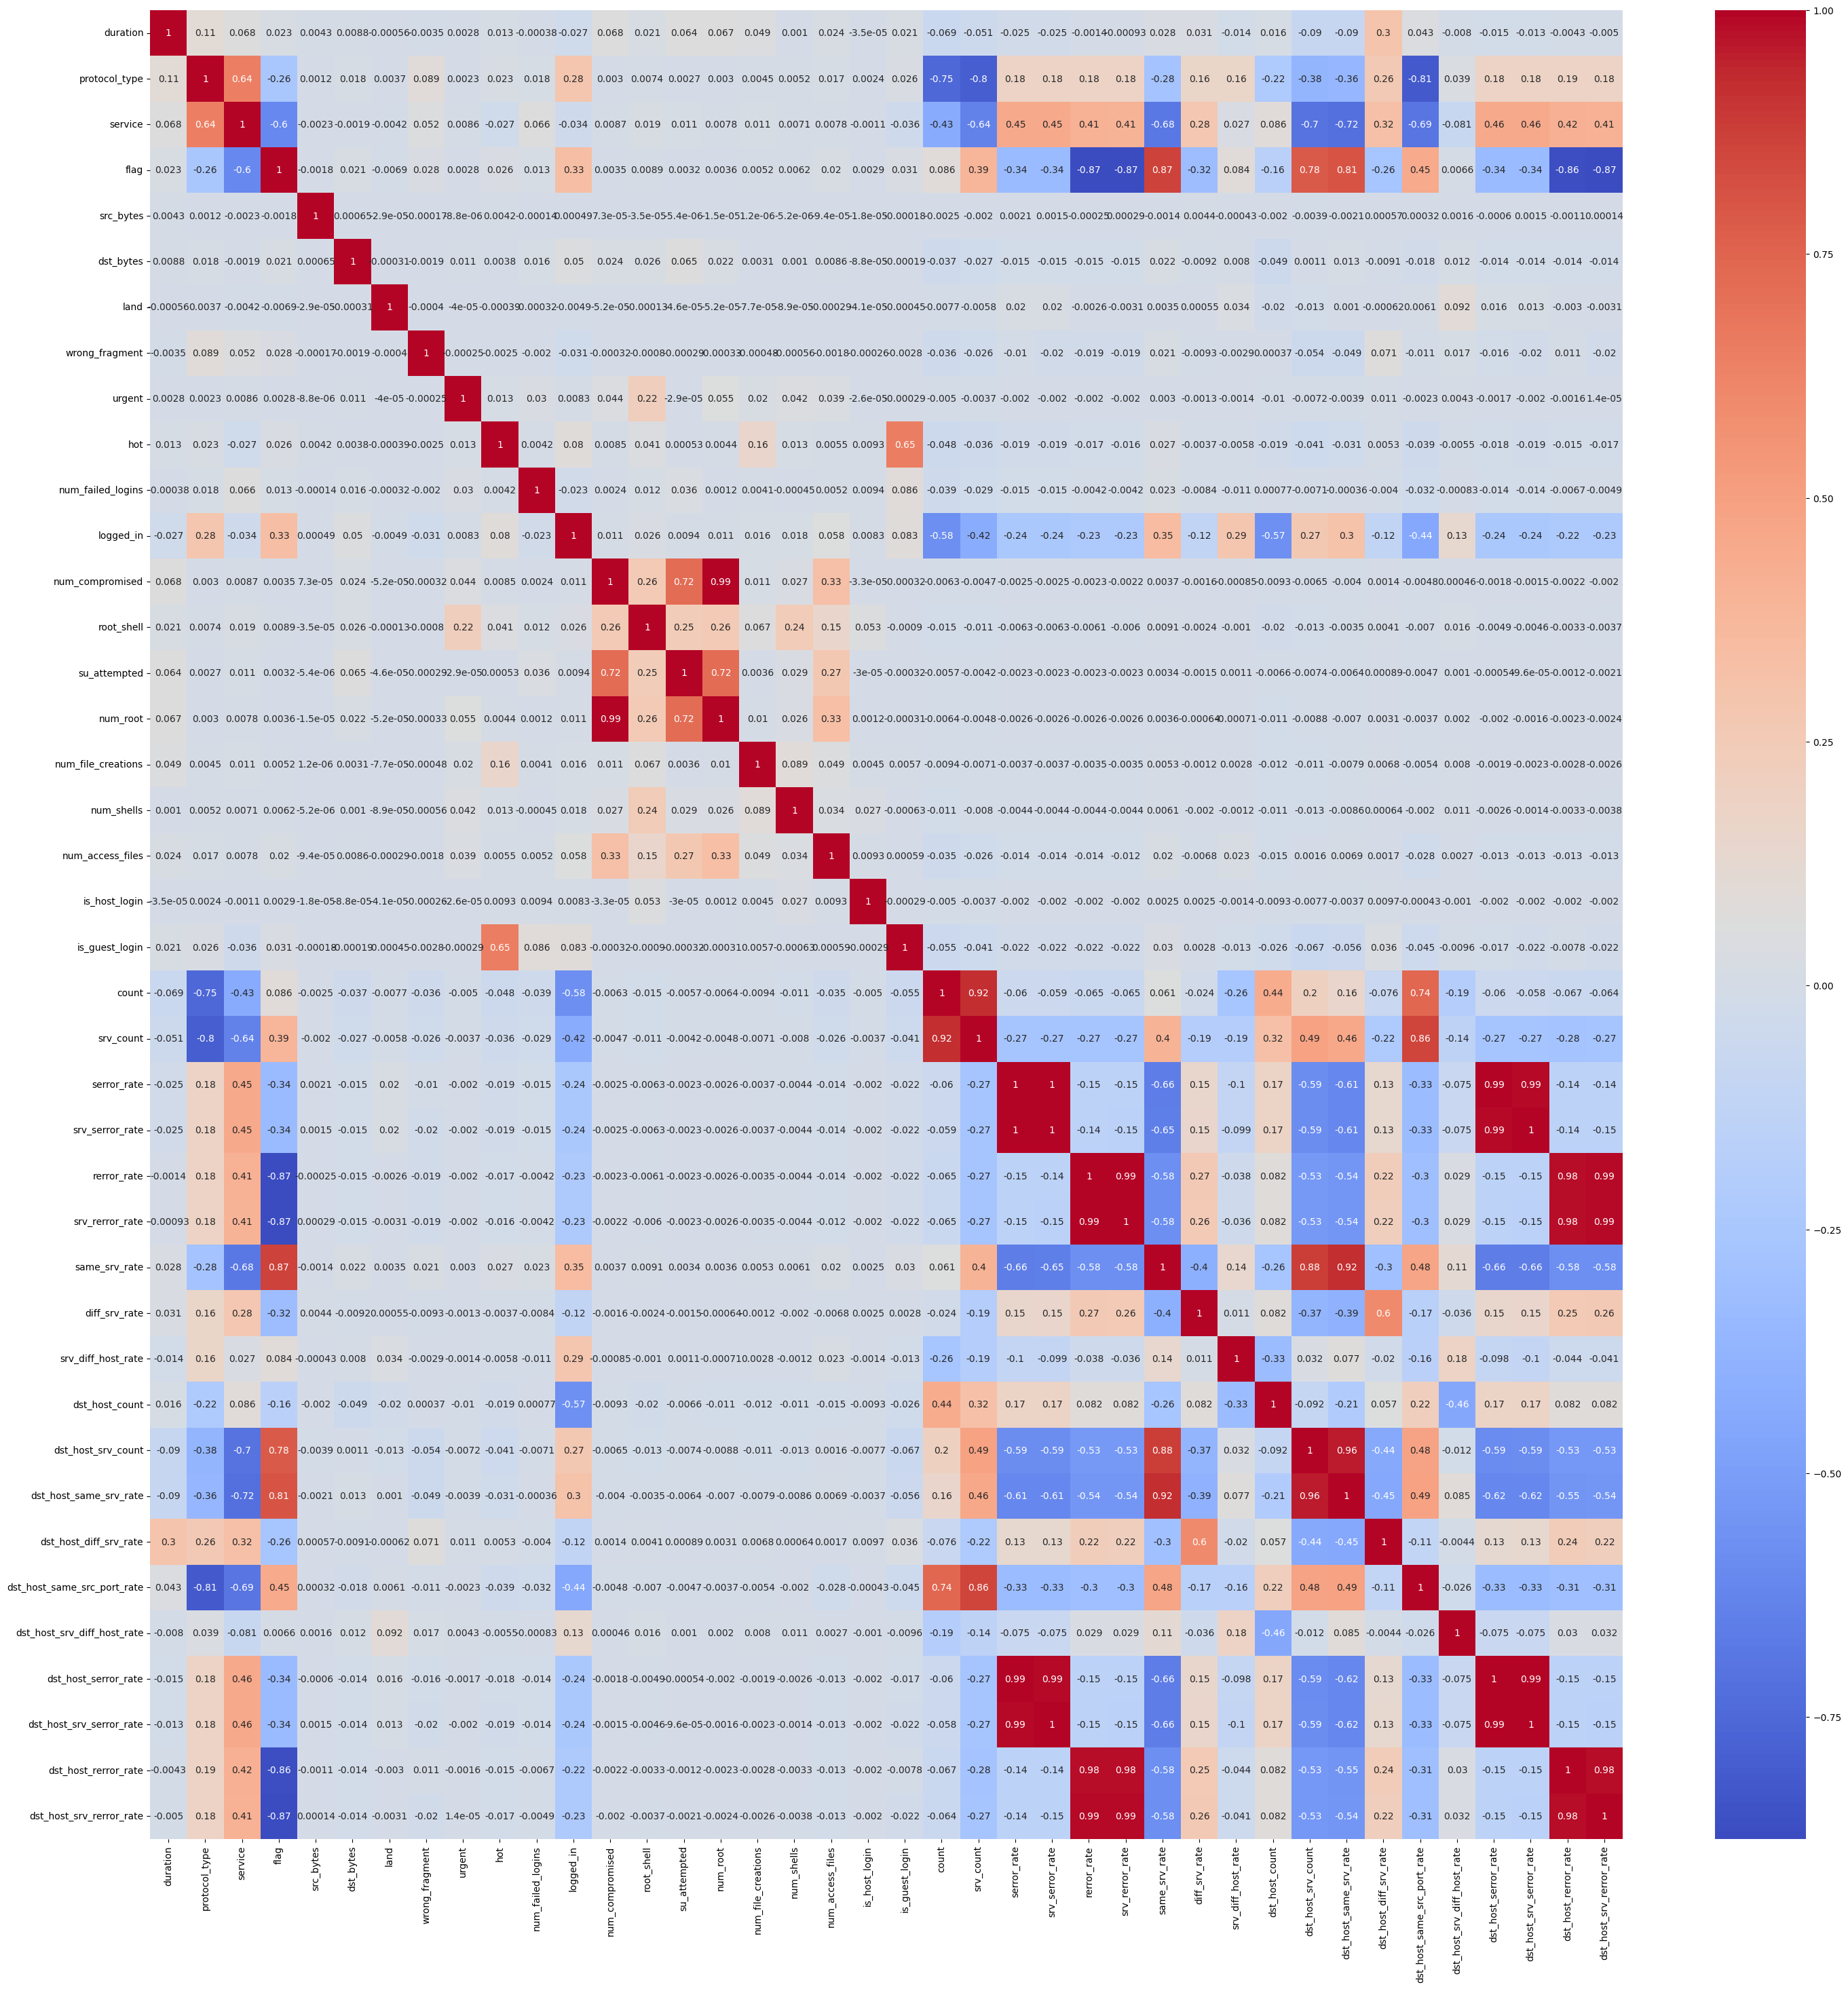

In [11]:
plt.figure(figsize=(35,35))
import seaborn as sns
sns.heatmap(cor, annot = True,cmap= 'coolwarm')

# Some features have nearly equal correlation , so they have same effect , so drop features with corr >= 99%

In [12]:
import warnings
warnings.filterwarnings('ignore')
upper_tri = cor.where(np.triu(np.ones(cor.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.99)]
df = df.drop(columns=to_drop, axis=1)

In [13]:
train_df = df.iloc[:145586]
test_df = df.iloc[145586:]

## Dropping labels column

In [14]:
train_df_unlabeled=train_df.drop(['label'], axis=1)
test_df_unlabeled=test_df.drop(['label'], axis=1)

## As we have large range of numbers in some columns and small range in others , we will scale the data

In [15]:
new_cols=train_df_unlabeled.columns

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df_unlabeled=scaler.fit_transform(train_df_unlabeled)
test_df_unlabeled=scaler.fit_transform(test_df_unlabeled)

In [17]:
train_df_unlabeled=pd.DataFrame(train_df_unlabeled, columns = new_cols)
test_df_unlabeled=pd.DataFrame(test_df_unlabeled, columns = new_cols)

# Kmeans Class

In [18]:
def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))

In [19]:
import random
from tqdm import tqdm
class K_Means:
    def __init__(self, k=7, max_iter=300):
        self.k = k
        self.max_iter = max_iter

    def fit(self,data):
      self.centroids = {}
      self.centroids[0]=random.choice(data)
      # Initializing centroids with Kmeans++
      for i in range(1,self.k):
          dists = np.sum([euclidean(centroid, data) for centroid in self.centroids.values()], axis=0)
          dists /= np.sum(dists)
          new_centroid_idx, = np.random.choice(range(len(data)), size=1, p=dists)
          self.centroids[i] = data[new_centroid_idx]

      for iter in tqdm(range(self.max_iter)):
          self.classifications = {} ## This dictionary will contain centroid index as key and the assigned points as values
          self.indeces={}
          for i in range(self.k):
              self.classifications[i] = [] # Empty list for each centroid to append data points in it
              self.indeces[i] = [] # Empty list for each centroid to append index of point in it

          for i,featureset in enumerate(data):
              distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids] ## calculate distance between the point and each centroid
              classification = np.argmin(distances) #get the minimum distance
              self.classifications[classification].append(featureset) ## add data point to the corresponding centroid
              self.indeces[classification].append(i)

          prev_centroids = dict(self.centroids)
          for classification in self.classifications:
              self.centroids[classification] = np.mean(self.classifications[classification],axis=0) ## update centroids according to clusters
          for centroid in self.centroids:
            if np.isnan(self.centroids[centroid]).any():
              print("YA SATEER")
              self.centroids[centroid] = prev_centroids[centroid]

          if prev_centroids.keys() == self.centroids.keys() and all(np.allclose(prev_centroids[k], self.centroids[k]) for k in prev_centroids.keys()):
              break

    def predict(self,data): # takes a data point
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification # return the assigned centroid

In [20]:
def prec(train_df,k,km,test):
  prec=[]
  summ=0
  data_size=len(train_df.index)
  for i in range(k):
    cluster_size=len(km.indeces[i])
    maj_of_cluster=list(Counter(test[i]).most_common())[0][1]
    count_in_cluster=len(km.indeces[i])
    prec.append((maj_of_cluster/count_in_cluster)*100)
    summ+=(cluster_size/data_size)*(maj_of_cluster/count_in_cluster)
  return prec,summ

In [21]:
def rec(train_df,k,km,test):
  rec=[]
  sum=0
  data_size=len(train_df.index)
  for i in range(k):
    cluster_size=len(km.indeces[i])
    maj_of_cluster=list(Counter(test[i]).most_common())[0][1]
    num_of_maj_in_data=len(train_df[train_df['label']==str(list(Counter(test[i]).most_common())[0][0])].index)
    rec.append((maj_of_cluster/num_of_maj_in_data)*100)
    sum+=(cluster_size/data_size)*(maj_of_cluster/num_of_maj_in_data)
  return rec,sum

In [39]:
ks=[7, 15, 23, 31,45]
train_size=len(train_df.index)
for k in ks:
  print("*************** K = "+str(k)+" start ***************")
  km=K_Means(k)
  km.fit(train_df_unlabeled.to_numpy())
  print("---------------------")
  test=[]
  for i in range(k):
    row=[]
    for j in tqdm(range(len(km.classifications[i]))):
      index=km.indeces[i][j]
      label=train_df.iloc[index,35]
      row.append(label)
    test.append(row)
  majority={}
  for i in range(k):
    majority[i]=list(Counter(test[i]).most_common())[0][0]  
  prec_list,total_prec=prec(train_df,k,km,test)
  rec_list,total_rec=rec(train_df,k,km,test)
  f1=(2*total_prec*total_rec)/(total_prec+total_rec)
  cond_entropy=0
  for cluster in range(k):
    cond_entropy_cluster = 0
    counts=list(np.unique(test[cluster],return_counts=True)[1])
    cluster_size=len(km.classifications[cluster])
    for count in counts:
      cond_entropy_cluster += -1*(count/cluster_size)*np.log2(count/cluster_size)
    cond_entropy += ((cluster_size/train_size) * cond_entropy_cluster)
  print("Training Evaluation:")
  print("Precision = "+str(total_prec)+" , recall = "+str(total_rec)+" , f1-score = "+str(f1)+" and conditional entropy = "+str(cond_entropy))
  print("Test Evaluation:")
  y_true=[]
  y_pred=[]
  for index,entry in enumerate(test_df_unlabeled.to_numpy()):
    if test_df.iloc[index,35] in list(set(majority.values())):
      y_true.append(test_df.iloc[index,35])
      y_pred.append(km.predict(entry))
    else:
      continue
  y_predict=[]
  for i in range(len(y_pred)):
    y_pred[i]=majority[y_pred[i]]
  from sklearn.metrics import precision_score,f1_score,recall_score,accuracy_score
  macro_precision = precision_score(y_true, y_pred, average='macro')
  print("Macro-averaged precision:", macro_precision)
  macro_recall = recall_score(y_true, y_pred, average='macro')
  print("Macro-averaged recall:", macro_recall)
  macro_f1 = f1_score(y_true, y_pred, average='macro')
  print("Micro-averaged F1 score:", macro_f1)
  print("Accuracy = ",str(accuracy_score(y_pred,y_true)))
  print("---------------------------------------------------------------")
  print("*************** K = "+str(k)+" end ***************")
  print("------------------------------------------------------------------------------------------------------------------------------------------------------")

*************** K = 7 start ***************


 10%|▉         | 29/300 [03:55<36:42,  8.13s/it]


---------------------


100%|██████████| 6524/6524 [00:00<00:00, 39430.30it/s]


Training Evaluation:
Precision = 0.9273693899138653 , recall = 0.42917614407224225 , f1-score = 0.5867916836147079 and conditional entropy = 0.3714553144015881
Test Evaluation:
Macro-averaged precision: 0.998324623475547
Macro-averaged recall: 0.9983348030696837
Micro-averaged F1 score: 0.998329657544675
Accuracy =  0.9983304383021063
---------------------------------------------------------------
*************** K = 7 end ***************
------------------------------------------------------------------------------------------------------------------------------------------------------
*************** K = 15 start ***************


  8%|▊         | 24/300 [06:25<1:13:56, 16.07s/it]


---------------------


100%|██████████| 9359/9359 [00:00<00:00, 43002.50it/s]


Training Evaluation:
Precision = 0.9588353275727061 , recall = 0.18915206842510765 , f1-score = 0.3159715622692924 and conditional entropy = 0.22914588139405054
Test Evaluation:
Macro-averaged precision: 0.9982464466587853
Macro-averaged recall: 0.9982612745908936
Micro-averaged F1 score: 0.998253741147523
Accuracy =  0.9982545491340202
---------------------------------------------------------------
*************** K = 15 end ***************
------------------------------------------------------------------------------------------------------------------------------------------------------
*************** K = 23 start ***************


  9%|▉         | 28/300 [11:05<1:47:49, 23.78s/it]


---------------------


100%|██████████| 21018/21018 [00:00<00:00, 40249.84it/s]


Training Evaluation:
Precision = 0.9657109886939679 , recall = 0.2074062851914305 , f1-score = 0.341474008084764 and conditional entropy = 0.16607229075281393
Test Evaluation:
Macro-averaged precision: 0.9348226517453402
Macro-averaged recall: 0.9158576747756249
Micro-averaged F1 score: 0.9185216556290635
Accuracy =  0.9944684485947206
---------------------------------------------------------------
*************** K = 23 end ***************
------------------------------------------------------------------------------------------------------------------------------------------------------
*************** K = 31 start ***************


 19%|█▉        | 57/300 [29:30<2:05:46, 31.05s/it]


---------------------


100%|██████████| 3598/3598 [00:00<00:00, 43761.11it/s]


Training Evaluation:
Precision = 0.9688431579959611 , recall = 0.1480672137035512 , f1-score = 0.2568763090666427 and conditional entropy = 0.15793752721376714
Test Evaluation:
Macro-averaged precision: 0.790356886702061
Macro-averaged recall: 0.9327883063326121
Micro-averaged F1 score: 0.8275336955078112
Accuracy =  0.9983112583951302
---------------------------------------------------------------
*************** K = 31 end ***************
------------------------------------------------------------------------------------------------------------------------------------------------------
*************** K = 45 start ***************


 28%|██▊       | 85/300 [1:02:23<2:37:48, 44.04s/it]


---------------------


100%|██████████| 384/384 [00:00<00:00, 22530.15it/s]


Training Evaluation:
Precision = 0.9736650502108717 , recall = 0.10045884015321098 , f1-score = 0.18212659176353957 and conditional entropy = 0.12416276644556123
Test Evaluation:
Macro-averaged precision: 0.8235286253069906
Macro-averaged recall: 0.9014362107484573
Micro-averaged F1 score: 0.8310144892657866
Accuracy =  0.9971090753256242
---------------------------------------------------------------
*************** K = 45 end ***************
------------------------------------------------------------------------------------------------------------------------------------------------------
